In [1]:
%%capture
!python3 -m pip install pandas numpy matplotlib tensorflow tqdm bs4 IP2Location

In [2]:
import requests
import urllib3
from urllib.parse import urlparse, urljoin
import socket

from bs4 import BeautifulSoup
import chardet
import re
import json

import math
import statistics

import os
import IP2Location

import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras import Sequential
import tensorflow.keras.layers
import tensorflow.keras.losses

from matplotlib import pyplot

from sklearn.model_selection import train_test_split, KFold

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

import warnings
warnings.filterwarnings(action="ignore", module="urllib3")

2023-03-27 00:40:09.424637: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-27 00:40:09.424671: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
DOWNLOAD_CHUNK_SIZE = 50
TIMEOUT = (10, 10)

In [4]:
ip2location_database = IP2Location.IP2Location()
ip2location_database.open(os.path.join("location_data", "IP2LOCATION-LITE-DB11.BIN"))
def get_location(ip_addr=None, hostname=None):
    if(ip_addr is None and hostname is not None):
        try:
            ip_addr = socket.gethostbyname(hostname)
        except socket.error:
            print("Socket Error")
            return None
    location_data = ip2location_database.get_all(ip_addr)
    if(location_data.country_short == "-"):
        if(not ip_addr in location_database):
            location_data = requests.get("https://ipinfo.io/"+ip_addr+"/json").json()
            if("error" in location_data):
                raise Exception("Failed because error with download (probably daily api quota exceded)")
            location_database[ip_addr] = location_data
            location_database[ip_addr]["country_short"] = location_data["country"]
            location_database[ip_addr]["latitude"], location_database[ip_addr]["longitude"] = tuple(location_data["loc"].split(","))
    else:
        return json.loads(str(location_data).replace("'", "\""))
    return location_database[ip_addr]

In [5]:
def get_absolute_url_from_relative(original_url, new_url):
    if(new_url.startswith("javascript")):
        return None
    if(new_url.startswith("http")):
        return new_url
    url_with_scheme = "http://"+original_url if not original_url.startswith("http") else original_url
    parsed_url = urlparse(url_with_scheme)
    url_scheme = parsed_url.scheme
    url_host = parsed_url.netloc
    
    return urljoin(url_scheme+"://"+url_host, new_url)

In [6]:
def download_aux_data(content, original_url):
    aux = []
    soup = BeautifulSoup(content, 'html.parser')
    for a in tqdm(soup.find_all('a')):
        href = a.get('href')
        if(href is not None):
            url = get_absolute_url_from_relative(original_url, href)
            if(url is not None):
                hostname = urlparse(url).netloc
                json = get_location(hostname=hostname)
                if(json is None):
                    continue
                try:
                    columns = [
                        "hostname_"+hostname,
                        "ip_addr_"+json["ip"],
                        "latitude_"+json["latitude"],
                        "longitude"+json["longitude"],
                        "city_"+json["city"],
                        "region_"+json["region"],
                        "country_"+json["country_short"],
                    ]
                except KeyError:
                    print("Problem with JSON: ", json)
                    columns = []
                
                columns = [ re.compile('[\W_]+').sub('_', column) for column in columns ]
                
                aux = aux + columns
                
    return " ".join(aux)

In [7]:
def download_one(original_url, timeout=TIMEOUT):
    row = {}
    row["attempted_download"] = True

    url_with_scheme = "http://"+original_url if not original_url.startswith("http") else original_url
    parsed_url = urlparse(url_with_scheme)
    hostname = parsed_url.netloc
    
    try:
        row["hostname"] = hostname

        ip_addr = socket.gethostbyname(hostname)
        row["ip_addr"] = ip_addr

        r = requests.get(url_with_scheme, verify=False, timeout=timeout)

        row["status_code"] = r.status_code
        encoding = chardet.detect(r.content)['encoding']
        if(encoding == None):
            print("Decoding Error")
        try:
            content = r.content.decode(encoding)
            row["content"] = content
        except:
            try:
                content = r.content.decode("utf")
            except:
                content = None
                print("Decoding Error")
            
        if(content is not None):
            row["aux"] = download_aux_data(content, original_url)
            row["words"] = " ".join(re.compile('[\W_]+').sub(' ', BeautifulSoup(content, 'html.parser').get_text()).split(" "))
        
        redirects = 0
        for r_history in r.history:
            if(r_history.status_code == 301):
                redirects = redirects + 1
        row["redirects"] = redirects

        json = get_location(ip_addr=ip_addr)
        if(json is None):
            return row
        try:
            row["latitude"] = json["latitude"]
            row["longitude"] = json["longitude"]
            row["city"] = json["city"]
            row["region"] = json["region"]
            row["country"] = json["country_short"]

        except KeyError:
            print("Problem with JSON: ", json)
        
            
        

    except socket.error:
        print("Socket Error")
        
    except UnicodeError:
        print("Unicode Error")
    
    return row

In [8]:
#raw_data.loc[raw_data[raw_data["attempted_download"] == True].index[-500:], "attempted_download"] = False
#raw_data
#raw_data.to_csv("./data.csv")

In [9]:
def download_chunk(chunk_size=DOWNLOAD_CHUNK_SIZE, timeout=TIMEOUT):
    global raw_data
    if(len(raw_data[raw_data["attempted_download"] == True].index) != 0):
          start = raw_data[raw_data["attempted_download"] == True].index[-1]+1
    end = start + chunk_size
    end = end if len(raw_data["url"]) > end else len(raw_data["url"])
    
    print("Downloading %d more rows ([%d:%d])" % (chunk_size, start, end))
    for row_index in tqdm(range(start, end)):
        row = download_one(raw_data.loc[row_index, "url"], timeout=timeout)
        if(len(list(row)) > 0):
            raw_data.loc[row_index, list(row)] = row.values()

In [10]:
def load_data():
    global raw_data, location_database
    
    raw_data = pd.read_csv("./raw_data.csv")
    raw_data["attempted_download"] = False
    
    try:
        with open("./location_data.json", 'r') as file:
            location_database = json.load(file)
        file.close()
    except FileNotFoundError:
        location_database = {}

    try:
        raw_data = pd.read_csv("./data.csv", index_col=0)
        if(DOWNLOAD_CHUNK_SIZE > 0):
            download_chunk()
            raw_data.to_csv("./data.csv")
            with open("./location_data.json", 'w') as file:
                json.dump(location_database, file)
            file.close()

    except FileNotFoundError:
        download_chunk()
        raw_data.to_csv("./data.csv")
        with open("./location_data.json", 'w') as file:
            json.dump(location_database, file)
        file.close()

    data = raw_data.copy()
    data = data.dropna()
    data = data.drop("attempted_download", axis=1)
    data = data[data["status_code"] == 200]
    data = data.drop("status_code", axis=1)
    data = data.reset_index(drop=True)
    data["redirects"] = data["redirects"].astype(str)
    return data

In [11]:
# raw_data = pd.read_csv("./data.csv", index_col=0)
# loc = raw_data[raw_data["loc"].notna()]["loc"].str.split(",", expand=True)
# raw_data["latitude"] = loc[0]
# raw_data["longitude"] = loc[1]
# raw_data = raw_data.drop("loc", axis=1)
# raw_data.to_csv("./data.csv")

In [12]:
raw_data = pd.read_csv("./raw_data.csv")
raw_data

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,www.gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


In [13]:
for i in range(1):
    data = load_data()
data

/tmp/ipykernel_191952/3493489388.py:2: DtypeWarning: Columns (4,5,7,9,10,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  data = load_data()


  0%|          | 0/50 [00:00<?, ?it/s]

Socket Error


0it [00:00, ?it/s]

Socket Error


  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Socket Error


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

Socket Error
Socket Error
Socket Error
Socket Error
Socket Error
Socket Error
Socket Error


0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/194 [00:00<?, ?it/s]

Socket Error
Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}
Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}
Socket Error
Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Socket Error
Socket Error


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}
Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}


0it [00:00, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Socket Error
Socket Error
Socket Error


  0%|          | 0/261 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}
Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}


  0%|          | 0/926 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}
Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}
Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}
Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}


  0%|          | 0/409 [00:00<?, ?it/s]

Unicode Error
Socket Error


0it [00:00, ?it/s]

Socket Error


  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}


  0%|          | 0/3 [00:00<?, ?it/s]

Socket Error


  0%|          | 0/180 [00:00<?, ?it/s]

Socket Error
Socket Error
Socket Error


  0%|          | 0/44 [00:00<?, ?it/s]

Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}
Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}
Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}
Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}


  0%|          | 0/14 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}


  0%|          | 0/333 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

,url,type,hostname,ip_addr,content,redirects,city,region,country,org,words,aux,latitude,longitude
0,http://larcadelcarnevale.com/catalogo/palloncini,defacement,larcadelcarnevale.com,185.53.177.31,"<!DOCTYPE html>\n<html data-adblockkey=""MFwwDQ...",0.0,Munich,Bavaria,DE,AS19905 Neustar Security Services,larcadelcarnevale com Buy this domain larcade...,hostname_secure_voodoo_com ip_addr_192_64_146_...,48.1374,11.5755
1,https://docs.google.com/spreadsheet/viewform?f...,phishing,docs.google.com,172.253.115.102,"<!DOCTYPE html><html lang=""en"" class=""HB1eCd-U...",2.0,Washington,"Washington, D.C.",US,AS15169 Google LLC,Sorteo Notebook Diciembre 2012JavaScript isn t...,hostname_accounts_google_com ip_addr_142_251_1...,38.8951,-77.0364
2,http://interpark.com/displaycorner/FreeMarket....,benign,interpark.com,211.233.74.23,"\r\n\r\n<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTM...",0.0,Seoul,Seoul,KR,AS3786 LG DACOM Corporation,Shopper s Heaven 인터파크 홈 리빙 세탁 청소용품 리빙 최신 등록순 ...,hostname_interpark_com ip_addr_211_233_74_23 l...,37.566,126.9784
3,http://www.pn-wuppertal.de/links/2-linkseite/5...,defacement,www.pn-wuppertal.de,217.160.0.93,"\n<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0...",1.0,Karlsruhe,Baden-Wurttemberg,DE,AS8560 IONOS SE,Links KontaktAnfahrtDatenschutzImpressum Home...,hostname_www_pn_wuppertal_de ip_addr_217_160_0...,49.0094,8.4044
4,http://www.parafiapiaski.pl/index.php?option=c...,defacement,www.parafiapiaski.pl,185.253.212.22,<!doctype html>\n<html>\n\n<head>\n\n<meta htt...,0.0,Warsaw,Mazovia,PL,AS48707 AS48707 OPS PL sp. z o.o.,AfterMarket pl domena parafiapiaski pl Domena...,hostname_www_aftermarket_pl ip_addr_185_253_21...,52.2298,21.0118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,http://grantland.com/hollywood-prospectus/2015...,benign,grantland.com,192.0.66.2,<!DOCTYPE HTML>\n<!--[if IEMobile 7 ]><html cl...,0.0,San Francisco,California,US,"AS2635 Automattic, Inc",Final 2015 Oscar Nomination Predictions Best ...,hostname_grantland_com ip_addr_192_0_66_2 loc_...,37.7509,-122.4153
328,http://9779.info/%E5%B9%BC%E5%84%BF%E7%B2%98%E...,malware,9779.info,160.153.63.37,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T...",0.0,Phoenix,Arizona,US,"AS398101 GoDaddy.com, LLC",幼儿粘贴画树叶图片图片展示 贴画网 树叶粘贴画 豆子粘贴画 剪贴画 拼贴画 布贴画 儿童贴...,hostname_www_9779_info ip_addr_160_153_63_37 l...,33.4484,-112.074
329,http://gessobh.com/projetos.html,defacement,gessobh.com,18.119.154.66,"<!DOCTYPE html>\n<html lang=""en"">\n<head>\n\n<...",0.0,Hilliard,Ohio,US,"AS16509 Amazon.com, Inc.",GessoBh com is for sale HugeDomains Skip to m...,hostname_gessobh_com ip_addr_18_119_154_66 loc...,40.0334,-83.1582
330,http://kakaku.com/kaden/antenna-others/ranking...,benign,kakaku.com,103.70.243.165,"\r\n<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4....",2.0,Tokyo,Tokyo,JP,"AS59123 Kakaku.com, Inc.",価格 com BS CSアンテナ 格安 激安 大幅値下げランキング BS CSアンテナ 格...,hostname_kakaku_com ip_addr_103_70_243_165 loc...,35.691,139.7679


In [14]:
feature_names = ["words", "aux", "city", "region", "country", "redirects", "latitude", "longitude"]

data["latitude"] = data["latitude"].astype(np.str)
data["longitude"] = data["longitude"].astype(np.str)

sl = tf.keras.layers.StringLookup(output_mode='one_hot')
sl.adapt(data["type"])

y = sl(list(data["type"]))

X_train, X_test, y_train, y_test = train_test_split(data[feature_names], y, test_size=0.33)

2023-03-27 00:44:51.835546: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-27 00:44:51.835586: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-27 00:44:51.835620: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (benjamin-XPS-13-9370): /proc/driver/nvidia/version does not exist
2023-03-27 00:44:51.835903: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 00:44:51.903539: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of th

In [25]:
max_features = 10000
sequence_length = 250
epochs = 10
folds = 3

def custom_standardization(input_data):
    return tf.strings.lower(input_data)

def get_vectorize_layer(column):
    vectorize_layer = tf.keras.layers.TextVectorization(
        standardize=custom_standardization,
        max_tokens=max_features,
        output_mode='int',
        output_sequence_length=sequence_length
    )
    vectorize_layer.adapt(data[column])
    return vectorize_layer

def get_string_lookup(column):
    lookup = tf.keras.layers.StringLookup(
        output_mode='one_hot',
        max_tokens=sequence_length,
        pad_to_max_tokens=True,
    )
    lookup.adapt(data[column])
    return lookup

inputs = tf.keras.Input(shape=(len(feature_names),), dtype=tf.string)
outputs = []
for i in range(len(feature_names)):
    feature_name = feature_names[i]
    flatten = tf.keras.layers.Flatten()
    if(feature_name == "latitude" or feature_name == "longitude"):
        outputs.append(flatten(tf.strings.to_number(inputs[:,i], out_type=tf.dtypes.float32)))
    else:
        embedding_layer = tf.keras.layers.Embedding(max_features, 5)
        if(feature_name == "words" or feature_name == "aux"):
            layer = get_vectorize_layer(feature_name)
        else:
            layer = get_string_lookup(feature_name)
        outputs.append(tf.keras.layers.Flatten()(embedding_layer(layer(flatten(inputs[:,i])))))
    
    
outputs = tf.concat(outputs, axis=-1)

sequential_model = tf.keras.Sequential([
    #tf.keras.layers.Flatten(),
    # tf.keras.Input(shape=outputs.shape[1:]),
    # tf.keras.layers.Conv1D(16, 3, activation='relu'),
    # tf.keras.layers.MaxPooling1D(),
    # tf.keras.layers.Conv1D(32, 3, padding='same', activation='relu'),
    # tf.keras.layers.MaxPooling1D(),
    # tf.keras.layers.Conv1D(64, 3, padding='same', activation='relu'),
    # tf.keras.layers.MaxPooling1D(),
    # tf.keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
    # tf.keras.layers.MaxPooling1D(),
    # tf.keras.layers.Conv1D(256, 3, padding='same', activation='relu'),
    # tf.keras.layers.MaxPooling1D(),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(15, activation='relu'),
    #tf.keras.layers.Dense(5, activation='relu'),
    #tf.keras.layers.GlobalAveragePooling1D(),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5)
])


model = tf.keras.Model(inputs=inputs, outputs=sequential_model(outputs) )
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()
sequential_model.summary()

kfold = KFold(n_splits=folds, shuffle=True)

histories = []
for train, validation in kfold.split(X_train, y_train):
    history = model.fit(
        X_train.iloc[train],
        y_train[train],
        validation_data=(X_train.iloc[validation], y_train[validation]),
        epochs=epochs,
        batch_size=1,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
    )
    histories.append(history)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_8 (Sli (None,)              0           input_2[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_9 (Sli (None,)              0           input_2[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_10 (Sl (None,)              0           input_2[0][0]                    
____________________________________________________________________________________________

In [26]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 9ms/step - loss: 0.4021 - accuracy: 0.8000


[0.4021042287349701, 0.800000011920929]

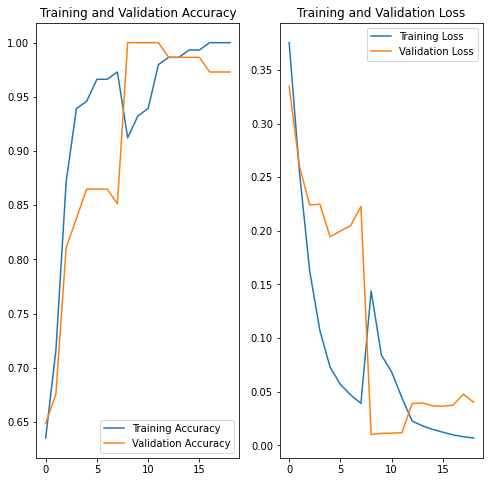

In [17]:
acc = []
val_acc = []
loss = []
val_loss = []
for history in histories:
    acc = acc + history.history['accuracy']
    val_acc = val_acc + history.history['val_accuracy']

    loss = loss + history.history['loss']
    val_loss = val_loss + history.history['val_loss']
    

epochs_range = range(len(acc))

pyplot.figure(figsize=(8, 8))
pyplot.subplot(1, 2, 1)
pyplot.plot(epochs_range, acc, label='Training Accuracy')
pyplot.plot(epochs_range, val_acc, label='Validation Accuracy')
pyplot.legend(loc='lower right')
pyplot.title('Training and Validation Accuracy')

pyplot.subplot(1, 2, 2)
pyplot.plot(epochs_range, loss, label='Training Loss')
pyplot.plot(epochs_range, val_loss, label='Validation Loss')
pyplot.legend(loc='upper right')
pyplot.title('Training and Validation Loss')
pyplot.show()

In [27]:
def to_type(one_hot_encoding):
    return sl.get_vocabulary()[np.argmax(tf.nn.softmax(one_hot_encoding))]

predictions = [ to_type(model.predict(X_test)[i]) for i in range(len(X_test)) ]
actuals = [ to_type(y_test[i]) for i in range(len(y_test)) ]

pd.DataFrame(np.array([actuals, predictions]).T, columns=["actual", "predicted"])

,actual,predicted
0,defacement,defacement
1,benign,benign
2,defacement,defacement
3,defacement,benign
4,defacement,defacement
...,...,...
105,defacement,defacement
106,defacement,defacement
107,defacement,benign
108,defacement,defacement


In [28]:
def predict(url):
    one = download_one(url)
    if(one is None):
        raise Exception("Failed to get data for this url")
    one = pd.DataFrame([one.values()], columns=list(one))
    one["redirects"] = one["redirects"].astype(str)
    one["latitude"] = one["latitude"].astype(str)
    one["longitude"] = one["longitude"].astype(str)
    return to_type(model.predict(one[feature_names]))

In [29]:
#print(predict("https://www.watchcartoonslive.la/watch/clarissa-explains-it-all-(1991a-1994)"))
print(predict("gogle.com"))
#print(predict("https://cnn.com/"))
#print(predict("https://love.com/"))

  0%|          | 0/17 [00:00<?, ?it/s]

benign


## TODO
1. Run this on the entire raw_data set
2. Do one-hot-encoding for the city, region, country, and type (probably using tensorflow/keras/sklearn)
3. Do text encoding on url and content (probably using tensorflow/keras/sklearn)
4. Split training and testing (using tensorflow/keras/sklearn)
5. Implement K-Fold cross-validation (probably using tensorflow/keras/sklearn)
6. Train CNN using tensorflow/keras/sklearn
7. Optinally, fine tune hyperparameters (e.g. epochs, activation function, layers, etc.)
8. Graph results



Add Normalize layers